## Bias testing for tasmin, tasmax and tasmean of CERRA 2m temperature data with respect to the insitu temperature observation data and ERA5 data paralelly
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'USegNet_downscaled_tasmean'
TRUE = 'CERRA_tasmean'
REFE = 'ERA5'

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [4]:
# CERRA tasmin data
if PREDICTAND == 'tasmin':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmin/2m_daily_min_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmax':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmax/2m_daily_max_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmean':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/ERA5_PRED/tasmean/USegNet_tasmean_ztuvq_500_850_mslp_dem_sa_doy_L1Loss_Adam_d1e-03_lr3e-04.nc")    

y_pred


<xarray.Dataset>
Dimensions:  (time: 8035, y: 38, x: 39)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
Data variables:
    tasmean  (time, y, x) float32 ...

In [5]:
y_pred = y_pred - 273.15

In [6]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmin/2m_daily_min_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmax/2m_daily_max_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmean/2m_daily_mean_temperature_1985_to_2016.nc")    


y_true

<xarray.Dataset>
Dimensions:  (time: 11688, x: 39, y: 38)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2016-12-31
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
Data variables:
    t2m      (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri May 05 16:29:19 2023: cdo remapbil,3035_tren...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [7]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [8]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 1995
Ending year: 2016


In [9]:
# ERA-5 reference dataset
if PREDICTAND == 'tasmin':
    y_refe = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/REANALYSIS/ERA5/2m_tasmin/regridded_tmin_1980_to_2016.nc")
    
if PREDICTAND == 'tasmax':
    y_refe = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/REANALYSIS/ERA5/2m_tasmax/regridded_tmax_1980_to_2016.nc")
    
if PREDICTAND == 'tasmean':
    y_refe = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/REANALYSIS/ERA5/2m_temperature/ERA5_2m_temperature_1981_2016.nc")
    
y_refe = y_refe.sel(time=y_pred.time)
y_refe = y_refe - 273.15


In [10]:
y_refe = y_refe.rename({'t2m': PREDICTAND})
y_refe

<xarray.Dataset>
Dimensions:  (time: 8035, x: 39, y: 38)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
Data variables:
    tasmean  (time, y, x) float32 0.2104 -0.3313 -1.049 ... 7.732 7.839 7.751
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 09 11:17:47 2023: cdo remapbil,grid_ext /home/sdhin...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [11]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_refe, y_pred = xr.align(y_true[PREDICTAND], y_refe[PREDICTAND], y_pred[PREDICTAND], join='override')
y_pred = y_pred.where(~np.isnan(y_true), other=np.nan)
y_refe = y_refe.where(~np.isnan(y_true), other=np.nan)

In [12]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [13]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [14]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [15]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.91
R2 on daily anomalies: 0.77


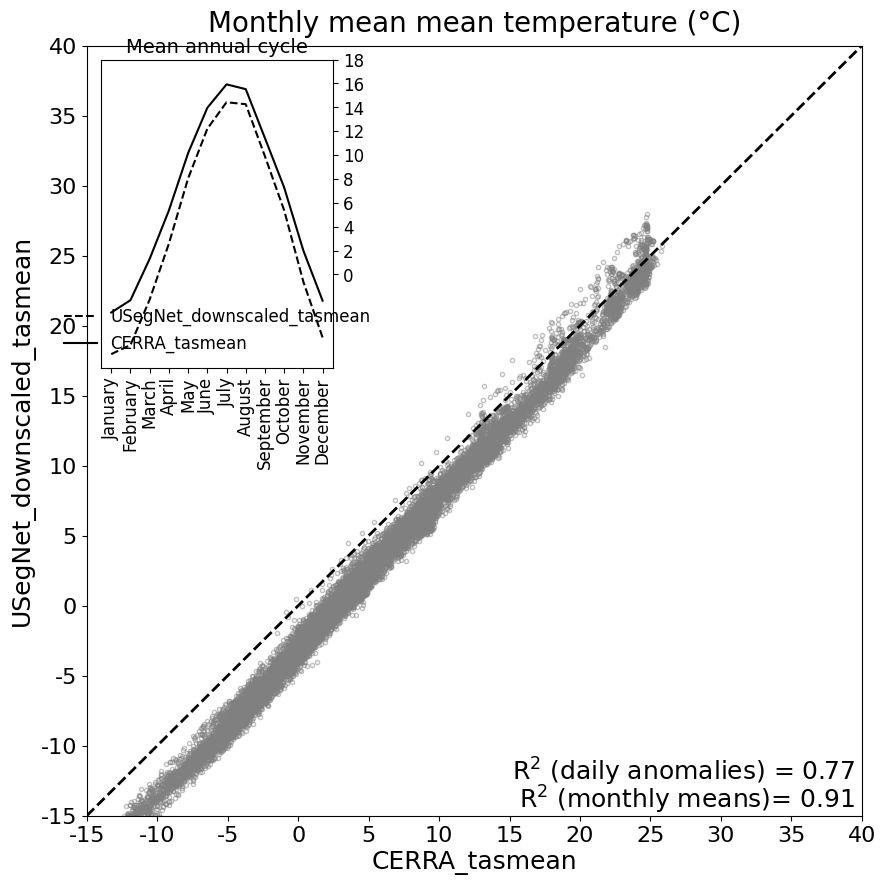

In [16]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)

# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='--', color='k', label=PRED)
axins.plot(y_true_ac.values, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

# save figure
fig.savefig('../Notebooks/Figures/{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Coefficient of determination: Spatially

In [17]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred.x), len(y_pred.y)), dtype=np.float32) * np.nan
for i, _ in enumerate(y_pred.x):
    for j, _ in enumerate(y_pred.y):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_71564/375282293.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_71564/375282293.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


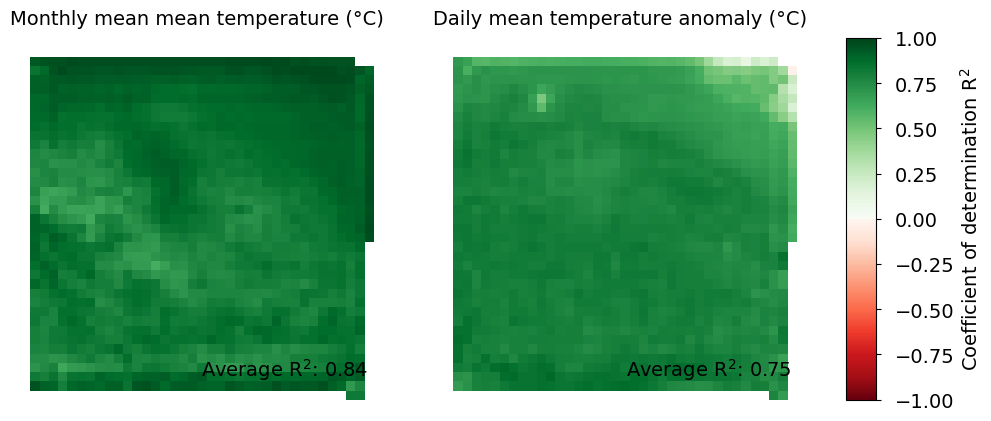

In [18]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = -1, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [19]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_refe_yearly_avg = y_refe.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
bias_yearly_avg_ref = y_refe_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))
print('({}) Yearly average bias of {}: {:.2f}°C'.format(REFE, PREDICTAND, bias_yearly_avg_ref.mean().item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average bias of tasmean: -2.43°C
(ERA5) Yearly average bias of tasmean: 0.39°C


In [20]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
mae_avg_ref = np.abs(y_refe_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))
print('({}) Yearly average MAE of {}: {:.2f}°C'.format(REFE,PREDICTAND, mae_avg_ref.mean().item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average MAE of tasmean: 2.47°C
(ERA5) Yearly average MAE of tasmean: 1.25°C


In [21]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
rmse_avg_ref = np.sqrt(((y_refe_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))
print('({}) Yearly average RMSE of {}: {:.2f}°C'.format(REFE, PREDICTAND, rmse_avg_ref.mean().item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average RMSE of tasmean: 2.64°C
(ERA5) Yearly average RMSE of tasmean: 1.68°C


In [22]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(1995): 0.99
(1996): 0.99
(1997): 0.99
(1998): 1.00
(1999): 0.99
(2000): 0.99
(2001): 0.99
(2002): 0.99
(2003): 0.99
(2004): 0.99
(2005): 0.99
(2006): 0.99
(2007): 0.99
(2008): 0.99
(2009): 0.99
(2010): 1.00
(2011): 1.00
(2012): 1.00
(2013): 1.00
(2014): 1.00
(2015): 0.98
(2016): 0.98
Yearly average Pearson correlation coefficient for tasmean: 0.98


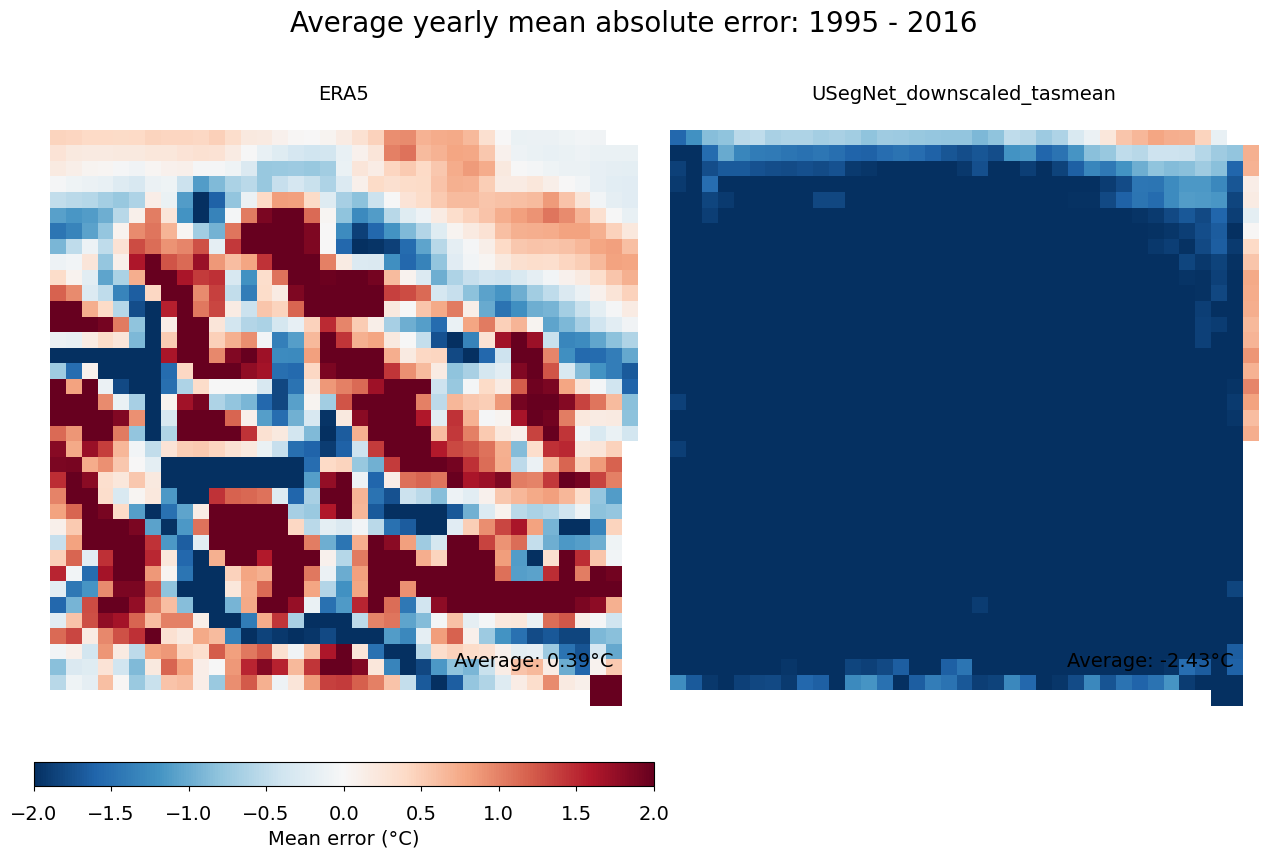

In [23]:
# plot yearly average bias of reference vs. prediction
vmin, vmax = -2, 2
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

# plot bias of ERA-5 reference
reference = bias_yearly_avg_ref.mean(dim='year')
im1 = axes[0].imshow(reference.values, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].text(x=reference.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(reference.mean().item()), fontsize=14, ha='right')

# plot MAE of Insitu:CERRA
prediction = bias_yearly_avg.mean(dim='year')
im2 = axes[1].imshow(prediction.values, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].text(x=reference.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(prediction.mean().item()), fontsize=14, ha='right')

# set titles
axes[0].set_title(REFE, fontsize=14, pad=10);
axes[1].set_title(PRED, fontsize=14, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off()

# adjust figure
fig.suptitle('Average yearly mean absolute error: {} - {}'.format(start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for dem
axes = axes.flatten()
# cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
#                              0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
# cbar_bias = fig.colorbar(im_dem, cax=cbar_ax_bias)
# cbar_bias.set_label(label='Elevation (m)', fontsize=14)
# cbar_bias.ax.tick_params(labelsize=14, pad=10)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.03])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Mean error (°C)', fontsize=14)
cbar_predictand.ax.tick_params(labelsize=14, pad=10)

# add metrics: MAE and RMSE
#axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.1f}'.format(mae_avg[NAMES[PREDICTAND]].item()) + 'mm day$^{-1}$', fontsize=14, ha='right')
#axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.1f}'.format(rmse_avg[NAMES[PREDICTAND]].item()) + 'mm$^2$ day$^{-2}$', fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_rbias_ERA.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

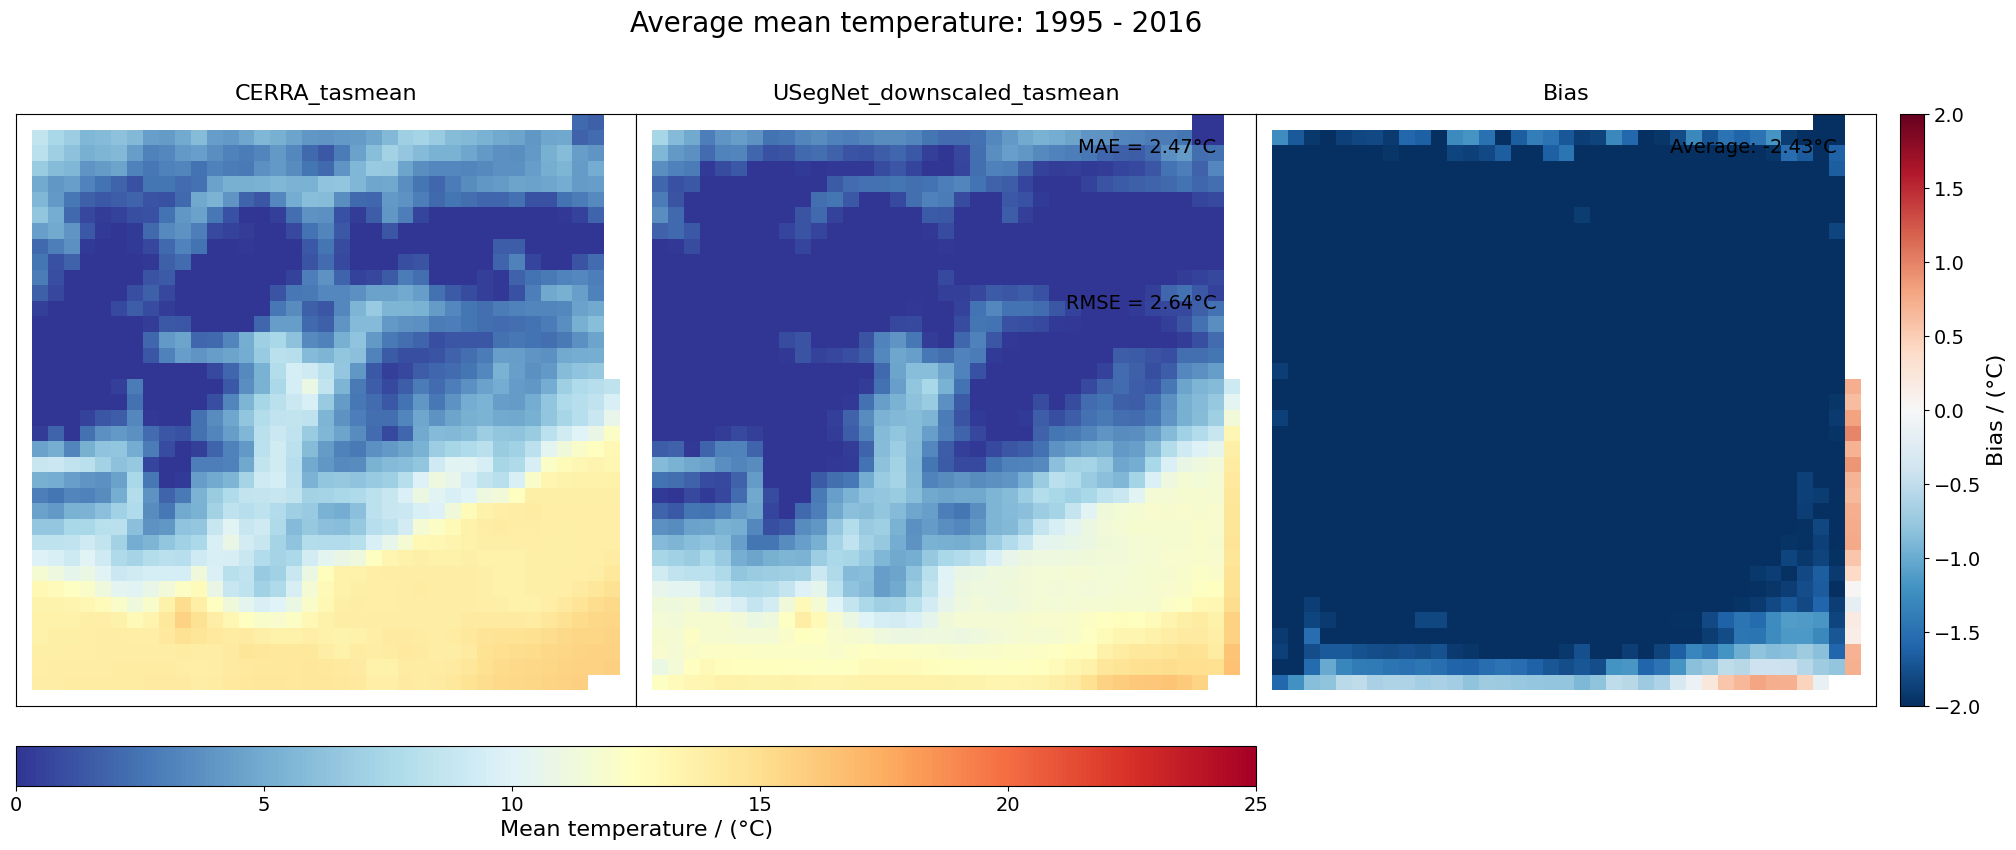

In [41]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [25]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
y_refe_snl = y_refe.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl
bias_snl_ref = y_refe_snl - y_true_snl

In [26]:
# print average bias per season: ERA-5
for season in bias_snl_ref.season:
    print('({}) Average bias of mean {} for season {}: {:.1f}°C'.format(REFE, PREDICTAND, season.item(), bias_snl_ref.sel(season=season).mean().item()))

(ERA5) Average bias of mean tasmean for season DJF: -0.0°C
(ERA5) Average bias of mean tasmean for season JJA: 0.5°C
(ERA5) Average bias of mean tasmean for season MAM: 0.6°C
(ERA5) Average bias of mean tasmean for season SON: 0.5°C


In [27]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Average bias of mean tasmean for season DJF: -3.4°C
(CERRA_tasmean:USegNet_downscaled_tasmean) Average bias of mean tasmean for season JJA: -1.5°C
(CERRA_tasmean:USegNet_downscaled_tasmean) Average bias of mean tasmean for season MAM: -2.8°C
(CERRA_tasmean:USegNet_downscaled_tasmean) Average bias of mean tasmean for season SON: -2.0°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

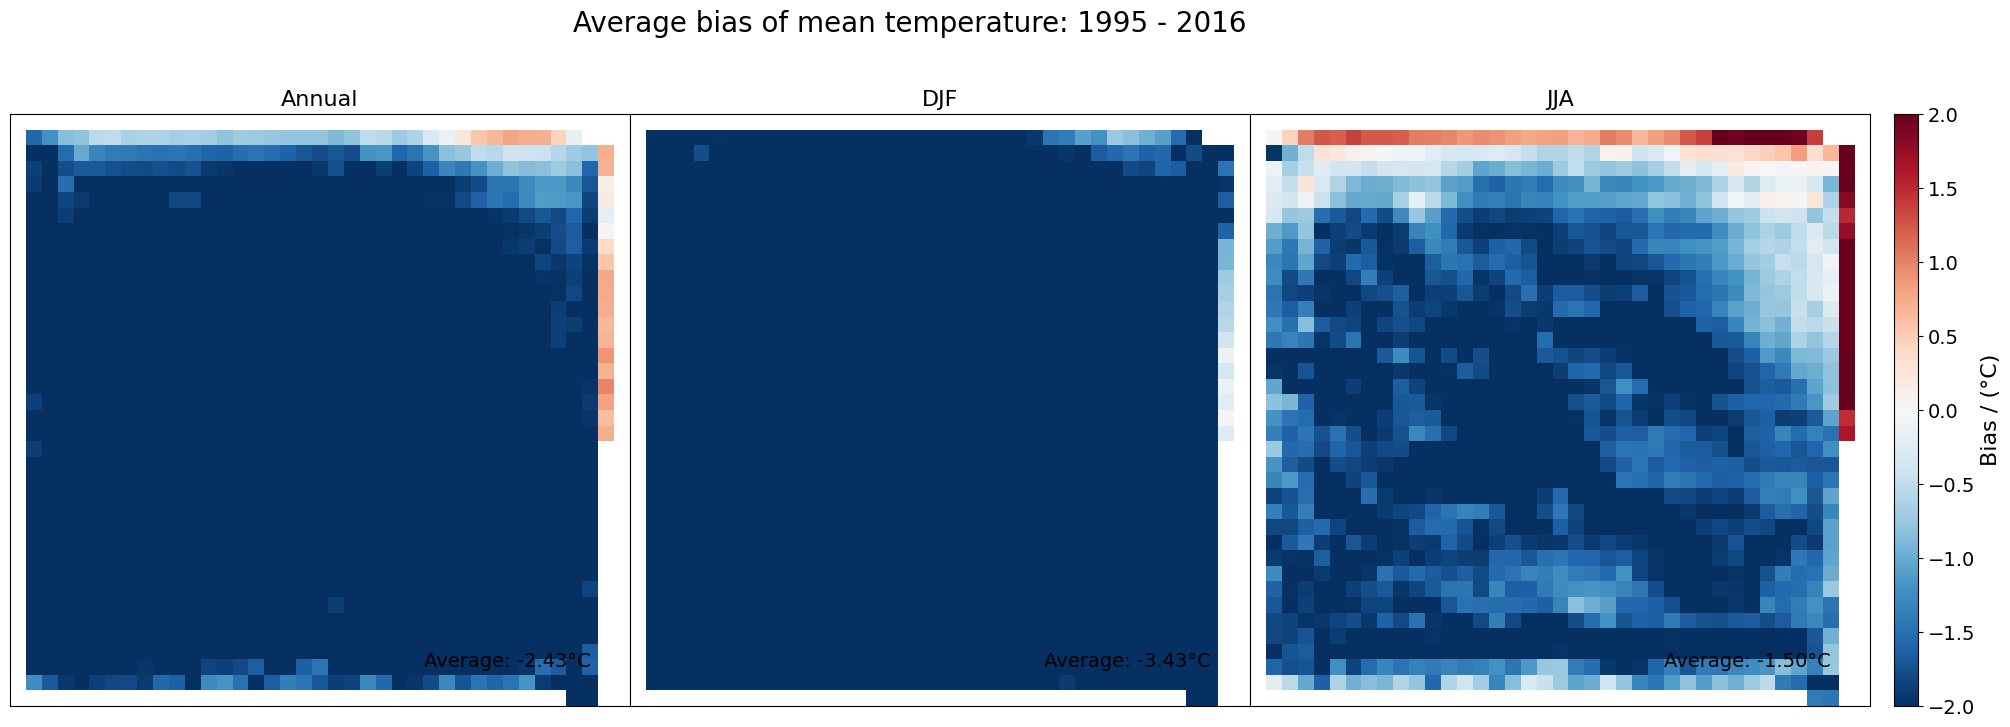

In [28]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [29]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [30]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')
    y_refe_ex = y_refe.groupby('time.year').quantile(quantile, dim='time')

In [31]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex
bias_ex_ref = y_refe_ex - y_true_ex

In [32]:
# bias of extreme quantile: ERA-5
print('({}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(REFE, quantile * 100, PREDICTAND, bias_ex_ref.mean().item()))

(ERA5) Yearly average bias for P98 of tasmean: 0.4°C


In [33]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average bias for P98 of tasmean: -1.3°C


In [34]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()
mae_ex_ref = np.abs(y_refe_ex - y_true_ex).mean()

In [35]:
# mae of extreme quantile: ERA-5
print('({}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(REFE, quantile * 100, PREDICTAND, mae_ex_ref.item()))

(ERA5) Yearly average MAE for P98 of tasmean: 1.7°C


In [36]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average MAE for P98 of tasmean: 1.6°C


In [37]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())
rmse_ex_ref = np.sqrt(((y_refe_ex - y_true_ex) ** 2).mean())

In [38]:
# rmse of extreme quantile: ERA-5
print('({}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(REFE, quantile * 100, PREDICTAND, rmse_ex_ref.item()))

(ERA5) Yearly average RMSE for P98 of tasmean: 2.1°C


In [39]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(CERRA_tasmean:USegNet_downscaled_tasmean) Yearly average RMSE for P98 of tasmean: 1.9°C


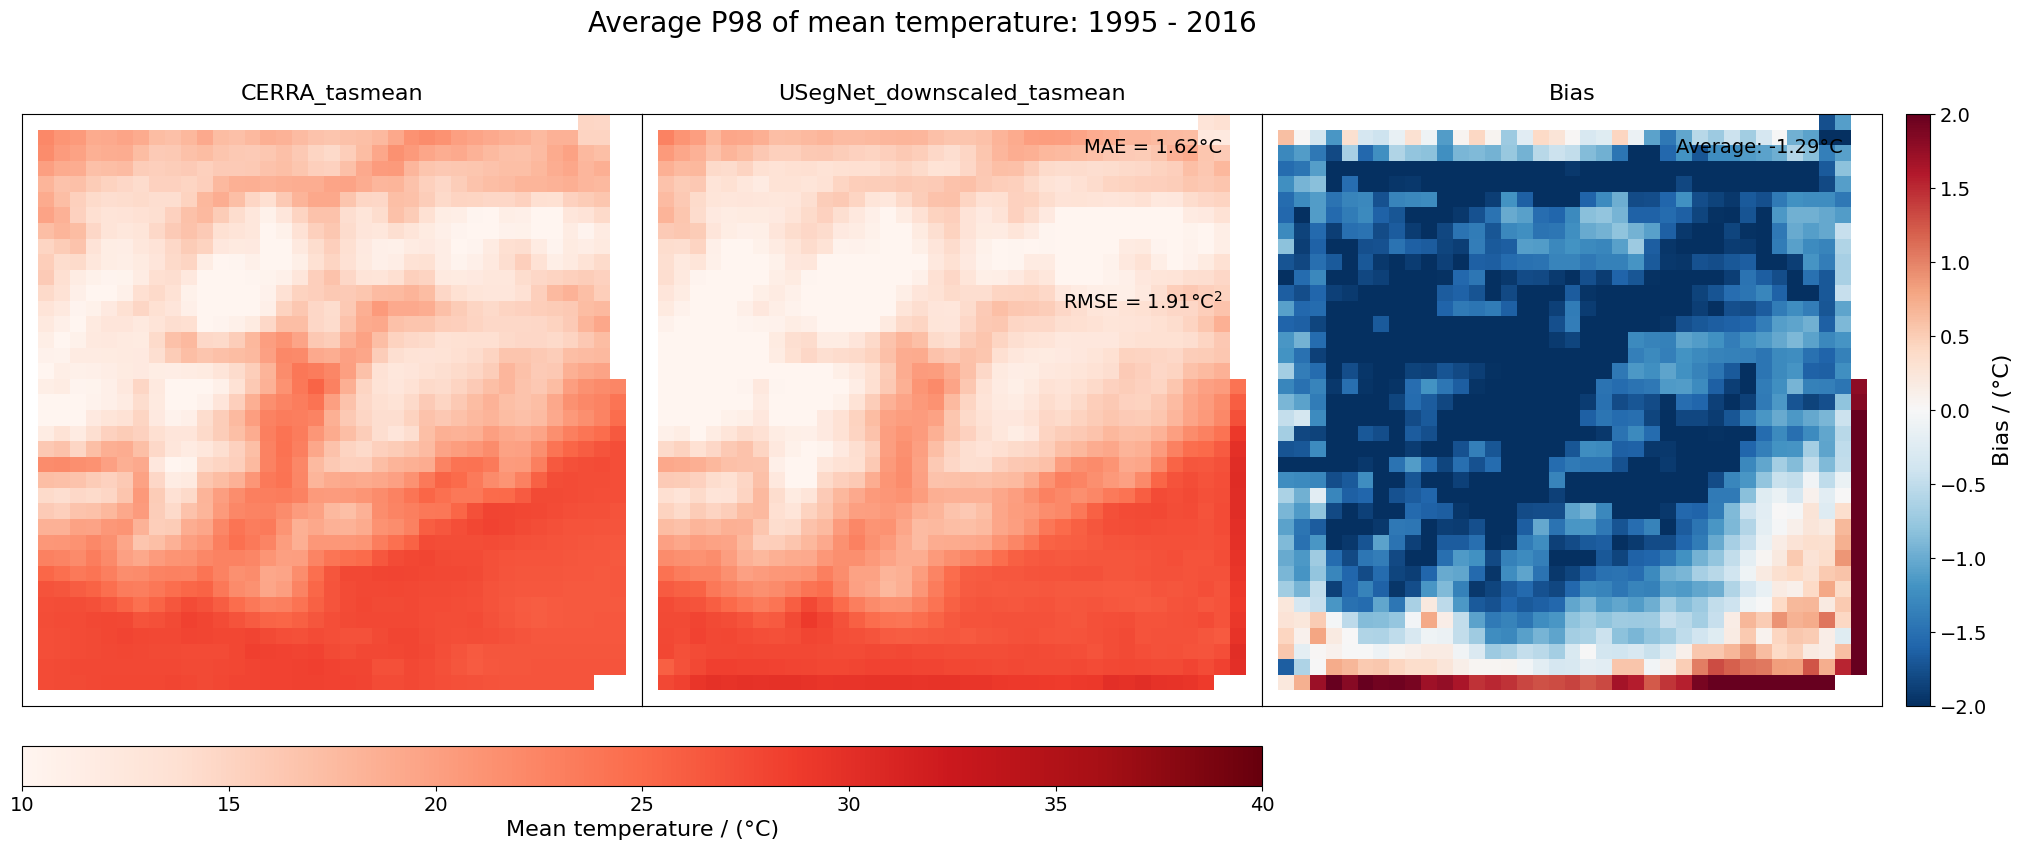

In [40]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')